# Box-Cox / Gnedin transformations for $n_\star$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize

### Load a file containing the relevant parameters from a MCMC chain

In [2]:
simple_igm=False
if simple_igm:
    fname='chain_igm_1.npz'
else:
    fname='chain_igm_8.npz'

In [3]:
# true values for central simulation
true_y=-2.297

In [4]:
data=np.load(fname)
y=data['n_star']
lnprob=data['lnprob']
# get rid of low-probability islands
max_lnprob=np.max(lnprob)
delta_lnprob_cut=30
if delta_lnprob_cut:
    mask=(max_lnprob-lnprob<delta_lnprob_cut)
    print('will use {} / {} points'.format(np.sum(mask),len(lnprob)))
    y=y[mask]
    lnprob=lnprob[mask]
prob=np.exp(lnprob-max_lnprob)

will use 448331 / 454400 points


### Fit Gaussian

In [5]:
def fit_gaussian(delta_lnprob_cut):
    cut_lnprob=max_lnprob-delta_lnprob_cut
    mask=lnprob>cut_lnprob
    yy=y[mask]
    # compute (robust) mean and std
    mean=np.median(yy)
    rms=1.4826*stats.median_abs_deviation(yy)
    return mean, rms

In [6]:
for cut in [20,50,200]:
    mean,rms=fit_gaussian(cut)
    print('{} -> {:.4f}, {:.5f}'.format(cut,mean,rms))

20 -> -2.3026, 0.00810
50 -> -2.3026, 0.00810
200 -> -2.3026, 0.00810


In [7]:
mean_y,rms_y=fit_gaussian(30)

### Make plot

In [8]:
def gaussian(n_star,mean,rms):
    return np.exp(-0.5*((n_star-mean)/rms)**2)

In [9]:
# print parameter range
min_y = y.min()
max_y = y.max()
print('{:.3f} < n_star < {:.3f}'.format(min_y,max_y))
plot_y=np.linspace(min_y,max_y,500)

-2.327 < n_star < -2.256


Text(0.6, 0.8, 'rms=0.0081')

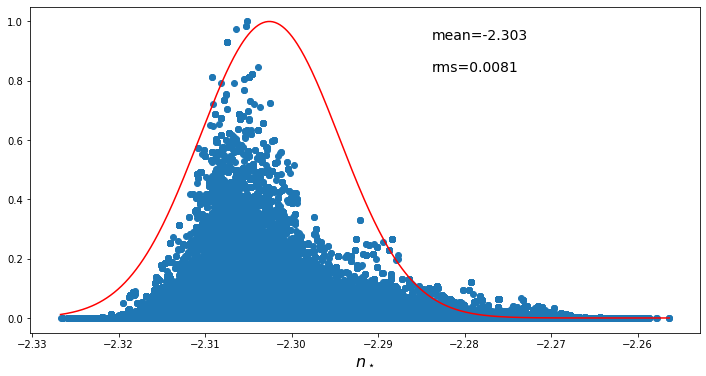

In [10]:
plt.figure(figsize=[12,6])
plt.scatter(y,prob)
plt.xlabel(r'$n_\star$',fontsize=16)
plt.plot(plot_y,gaussian(plot_y,mean_y,rms_y),color='red')
plt.annotate('mean={:.3f}'.format(mean),xy=(0.6,0.9),xycoords='axes fraction',fontsize=14)
plt.annotate('rms={:.4f}'.format(rms),xy=(0.6,0.8),xycoords='axes fraction',fontsize=14)

Text(0.5, 0, '$n_\\star$')

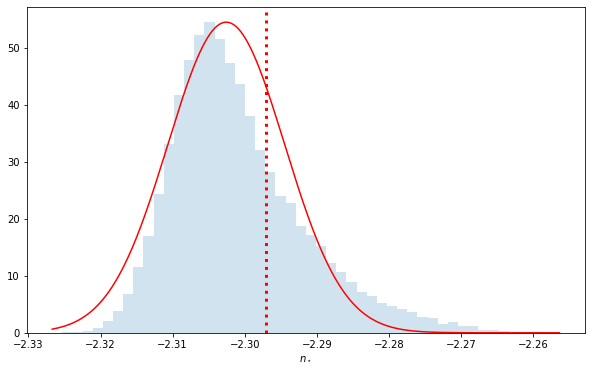

In [11]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(y,bins=50,alpha=0.2,density=True)
plt.plot(plot_y,np.max(counts)*gaussian(plot_y,mean_y,rms_y),color='red')
plt.axvline(x=true_y,ls=':',color='red',lw=3,label='true')
plt.xlabel(r'$n_\star$')

# Plot residuals

In [12]:
# compute normalised residuals
u=(y-mean_y)/rms_y
min_u=min(u)
max_u=max(u)
true_u=(true_y-mean_y)/rms_y
plot_u=np.linspace(min_u,max_u,500)

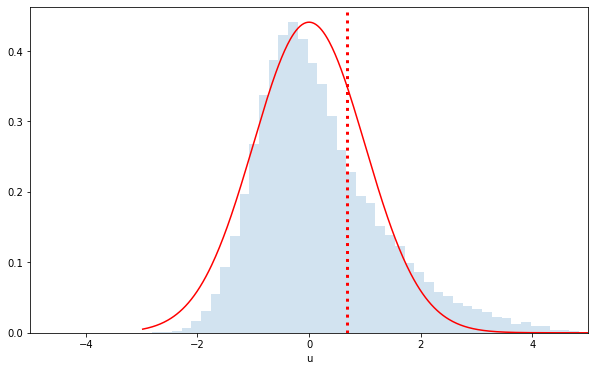

In [13]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(u,bins=50,alpha=0.2,density=True)
plt.plot(plot_u,np.max(counts)*gaussian(plot_u,0,1),color='red')
plt.axvline(x=true_u,ls=':',color='red',lw=3,label='true')
plt.xlim(-5,5)
plt.xlabel('u');

# Try Box-Cox transformation

In [14]:
u0=min_u-0.01
_,lam=stats.boxcox(u-u0)
print(lam)

0.19086455944680586


In [15]:
def boxcox(u,u0,lam):
    return ((u-u0)**lam-1)/lam

In [16]:
bc=boxcox(u,u0,lam)

In [17]:
min_bc=min(bc)
max_bc=max(bc)
# compute (robust) mean and std
mean_bc=np.median(bc)
rms_bc=1.4826*stats.median_abs_deviation(bc)
true_bc=boxcox(true_u,u0,lam)
# plotting 
plot_bc=np.linspace(min_bc,max_bc,500)

Text(0.5, 0, 'Box-Cox')

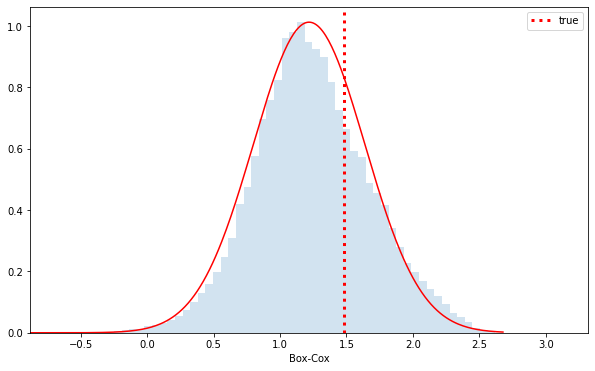

In [18]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(bc,bins=100,alpha=0.2,density=True)
plt.plot(plot_bc,np.max(counts)*gaussian(plot_bc,mean_bc,rms_bc),color='red')
plt.axvline(x=true_bc,ls=':',color='red',lw=3,label='true')
plt.xlim(mean_bc-5*rms_bc,mean_bc+5*rms_bc)
plt.legend()
plt.xlabel('Box-Cox')

# Try Gnedin transformation

In [19]:
def gnedin(u):
    us=u+0.2
    uf = us*(3.5-1.5*np.tanh(0.5*us))/3 - 0.03
    return uf

In [20]:
g=gnedin(u)

In [21]:
min_g=min(g)
max_g=max(g)
print('{:4f} < g < {:4f}'.format(min_g,max_g))
# compute (robust) mean and std
mean_g=np.median(g)
rms_g=1.4826*stats.median_abs_deviation(g)
true_g=gnedin(true_u)
plot_g=np.linspace(min_g,max_g,500)

-4.503411 < g < 3.924569


Text(0.5, 0, 'Gnedin')

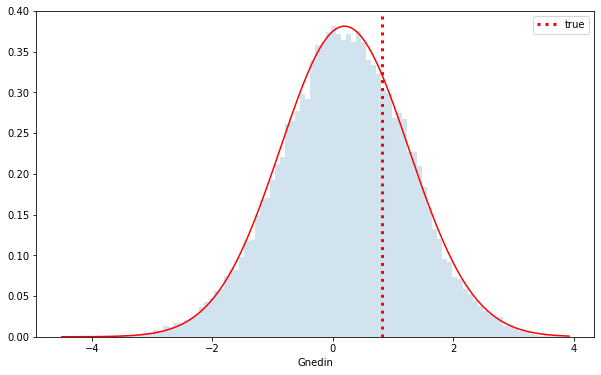

In [22]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(g,bins=100,alpha=0.2,density=True)
plt.plot(plot_g,np.max(counts)*gaussian(plot_g,mean_g,rms_g),color='red')
plt.axvline(x=true_g,ls=':',color='red',lw=3,label='true')
#plt.xlim(mean_g-5*rms_g,mean_g+5*rms_g)
plt.legend()
plt.xlabel('Gnedin')